### **Step 0**: Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

### **Step 1:** Reading the dataset
For this excercise I am using a loan approval dataset. The aim of the model will be to decide whether or not an applicant will be approved to take a loan from the bank. The data includes the person's income, the requested loan amount, their qualification etc.

In [3]:
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


Let's check if there are any null values and see the unique values of the categorical columns.

In [4]:
df.info()
print(df["education"].unique())
print(df["self_employed"].unique())
print(df["loan_status"].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   loan_id                   4269 non-null   int64 
 1   no_of_dependents          4269 non-null   int64 
 2   education                 4269 non-null   object
 3   self_employed             4269 non-null   object
 4   income_annum              4269 non-null   int64 
 5   loan_amount               4269 non-null   int64 
 6   loan_term                 4269 non-null   int64 
 7   cibil_score               4269 non-null   int64 
 8   residential_assets_value  4269 non-null   int64 
 9   commercial_assets_value   4269 non-null   int64 
 10  luxury_assets_value       4269 non-null   int64 
 11  bank_asset_value          4269 non-null   int64 
 12  loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB
['Graduate' 'Not Graduate']
['

The dataset is well balanced:

In [5]:
print(df["education"].value_counts())
print()
print(df["self_employed"].value_counts())
print()
print(df["loan_status"].value_counts())

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

self_employed
Yes    2150
No     2119
Name: count, dtype: int64

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


### **Step 2:** Cleaning up the dataset
The categorical columns only have 2 values, which can be represented as booleans. Because of that, I will replace them with 0 and 1 (1 being true and 0 being false value). I also dropped loan_id, because it doesn't affect the result.

In [6]:
df["education"] =  df["education"].map({
    "Graduate" : 1,
    "Not Graduate" : 0
})

df["self_employed"] =  df["self_employed"].map({
    "Yes" : 1,
    "No" : 0
})

df=df.drop(columns="loan_id")

df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


### **Step 3:** Train/test/validation split
I separate the target values from the rest of the columns, then I convert the target value into a categorical TensorFlow/Keras format.

In [7]:
X = df.drop(columns="loan_status")
y_temp = df["loan_status"]

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)
categories = list(le.classes_)
categories


['Approved', 'Rejected']

And now it's time for the train/test/validation split.

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### **Step 4:** Creating neural network structure
I am using Keras Dense layers to create the neural network structure. The input layer matches with the number of non-target values and the output layer has 2 nodes (accepted/rejected.)

In [9]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(10, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(18, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\zsolt\OneDrive - Óbudai egyetem\Deep Learning\deeplearning\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 11)             │            44 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │           198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532 (2.08 KB)

 Trainable params: 510 (1.99 KB)

 Non-trainable params: 22 (88.00 B)

### **Step 5:** Fitting data to the model
It's time to fit our cleaned-up dataset to our model.

In [10]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.6299 - loss: 3.1387 - val_accuracy: 0.6219 - val_loss: 2.6325
Epoch 2/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7172 - loss: 2.2089 - val_accuracy: 0.7578 - val_loss: 1.7859
Epoch 3/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8410 - loss: 1.4215 - val_accuracy: 0.8922 - val_loss: 1.0443
Epoch 4/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8936 - loss: 0.8257 - val_accuracy: 0.9078 - val_loss: 0.5736
Epoch 5/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8906 - loss: 0.4681 - val_accuracy: 0.9453 - val_loss: 0.3273
Epoch 6/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9080 - loss: 0.3354 - val_accuracy: 0.9219 - val_loss: 0.2829
Epoch 7/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9046 - loss: 0.3151 - val_accuracy: 0.9312 - val_loss: 0.2702
Epoch 8/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8963 - loss: 0.3221 - val_accuracy: 0.93

Here we can se how the training and validation loss changed during the training process.

<Axes: >

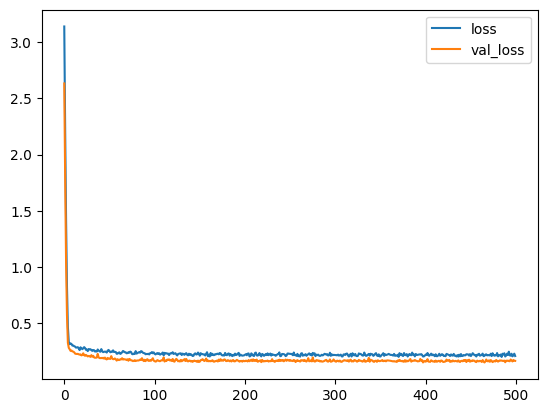

In [11]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

And the training and validation accuracy:

<Axes: >

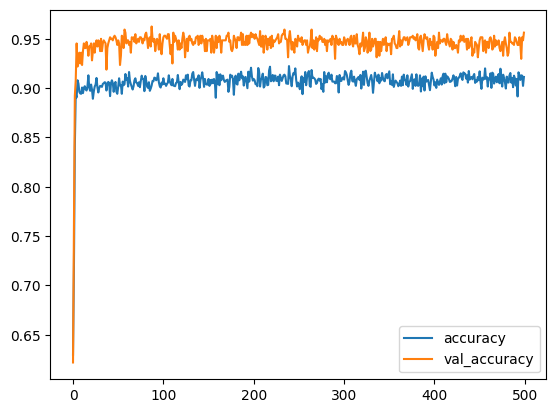

In [12]:
loss_df[['accuracy', 'val_accuracy']].plot()

And the test and train data evaluation:

In [13]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.16990868747234344, 0.9563182592391968]

Train data evaluation:
[0.1670457273721695, 0.9487951993942261]


### **Step 5:** Fitting data to the model
Using the test data, I predict the values with the model.

In [14]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
y_test = np.argmax(y_test, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


### **Step 6:** Metrics
The confusion matrix is a quick, useful and visible way to check how correct the model's predictions are. The main diagonal of the matrix contains most of the cases which means that my model can predict values quite well. The ratio of false negatives was a bit higher than the false positive, so the model was a bit stricter than the bank itself towards applicants.

Text(50.722222222222214, 0.5, 'True values')

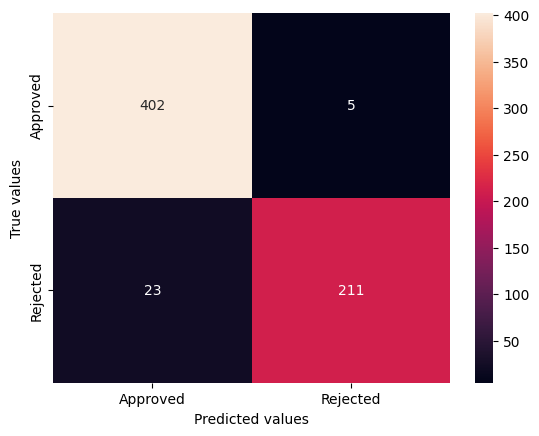

In [15]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted values')
plt.ylabel('True values')

Therefore, accuracy and precision was quite high and only recall is a bit lower because of the false negatives.

In [16]:
print(classification_report(y_test, test_predictions, target_names=categories))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    Approved       0.95      0.99      0.97       407
    Rejected       0.98      0.90      0.94       234

    accuracy                           0.96       641
   macro avg       0.96      0.94      0.95       641
weighted avg       0.96      0.96      0.96       641


Model overall accuracy: 95.63%


The AUC score also tends towards 1, proving that the model is good at classifying.

In [17]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.9895150191590913

### **Step 7:** trying out the model with imaginary new values
Let's see if our model can approve the loan for a wealthy entrepreneur with high income and credit score:

In [18]:
tester_row_approve = {
  'no_of_dependents' : 0,
  'education': 1,
  'self_employed': 1,
  'income_annum': 9600000, 
  'loan_amount': 29900000, 
  'loan_term': 24, 
  'cibil_score': 800,
  'residential_assets_value': 300000, 
  'commercial_assets_value': 570000,
  'luxury_assets_value': 9000000, 
  'bank_asset_value': 100000000
}

tester_row_approve = pd.DataFrame([tester_row_approve])
result = model.predict(tester_row_approve)[0]
result_text = categories[np.argmax(result)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted result: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted result: Approved

Probabilities by class:
['Approved', 'Rejected']
[0.9980198  0.00198017]


And now for an employee with 4 children that can hardly pay their bills at the end of the month.

In [19]:
tester_row_reject = {
  'no_of_dependents' : 4,
  'education': 0,
  'self_employed': 0,
  'income_annum': 5000, 
  'loan_amount': 500000, 
  'loan_term': 120, 
  'cibil_score': 250,
  'residential_assets_value': 50000, 
  'commercial_assets_value': 0,
  'luxury_assets_value': 0, 
  'bank_asset_value': 10000
}

tester_row_reject = pd.DataFrame([tester_row_reject])
result2 = model.predict(tester_row_reject)[0]
result_text = categories[np.argmax(result2)]

np.set_printoptions(precision=9, suppress=True)

print(f"Predicted result: {result_text}")
print()
print("Probabilities by class:")
print(categories)
print(result2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted result: Rejected

Probabilities by class:
['Approved', 'Rejected']
[0.006717915 0.9932821  ]


### **+1** Classic machine learning
I will use a scikit-learn's Decision Tree Classifier to see if a classical machine learning model could predict values better than the previous neural network.

Text(50.722222222222214, 0.5, 'True values')

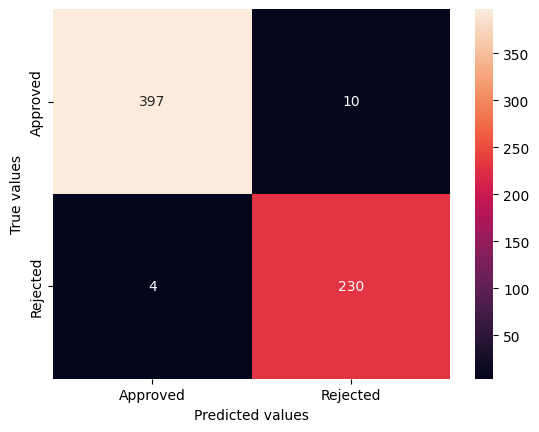

In [20]:
from sklearn.tree import DecisionTreeClassifier
classicmodel = DecisionTreeClassifier()

classicmodel.fit(X_train, y_train)
y_pred_classic = classicmodel.predict(X_test)

y_pred_classic = np.argmax(y_pred_classic, axis=1)

sns.heatmap(confusion_matrix(y_test, y_pred_classic), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted values')
plt.ylabel('True values')


In [21]:
print(classification_report(y_test, y_pred_classic, target_names=categories))

acc = accuracy_score(y_test, y_pred_classic)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

    Approved       0.99      0.98      0.98       407
    Rejected       0.96      0.98      0.97       234

    accuracy                           0.98       641
   macro avg       0.97      0.98      0.98       641
weighted avg       0.98      0.98      0.98       641


Model overall accuracy: 97.82%


In [22]:
roc_auc_score(y, classicmodel.predict(X), multi_class="ovr")

0.9921386569215486

### **Conclusion**
It turned out that for this dataset, a classical machine learning model could provide better results. The dataset is relatively simple and probably a neural network is just too complicated for this type of data.